# The role of topology in decentralized learning

In [4]:
import numpy as np
import numpy.random as rd
import torch
import scipy.optimize as optim
import matplotlib.pyplot as plt
from topologies import *

#hello

In [5]:
def DSGD_toypbm(lr, d, n, T, topologies, show):
    """
    D-SGD algorithm for the toy-problem defined in section 3 (minimization of 1/2*||x||^2)

    Inputs :
    ------------
    lr: learning rate
    d: dimension
    n: number of agents
    T: number of time steps
    topologies : list of topologies of the gossip matrix to try (symmetric, stochastic, size n*n)

    Prints at each iteration the state x obtained by worker i = 0
    """
    if show : 
        fig, ax = plt.subplots()
    final_results = []
    for topology in topologies:
        if topology != "Time-varying exponential":
            W = Matrix.w(scheme_for_string(topology, num_workers=n)).numpy()            
        x0 = rd.normal(0,1, size = (d))
        X = np.block([[x0]]*n)
        norms = []
        for _ in range(T):
            if topology == "Time-varying exponential":
                W = scheme_for_string(topology, num_workers=n).w(T).numpy()
            for i in range(n):
                v = rd.normal(0,1, size = (d,1))
                X[i,:] = X[i,:] - lr * v.dot(v.T).dot(X[i,:])
            X = W.dot(X)
            norms.append(np.mean(np.linalg.norm(X, axis = 1, ord = 2)))
        if show : 
            ax.plot(np.arange(0, T), norms, label = topology)
            ax.legend()
        final_results.append(norms[-1])
    if show: 
        plt.show()
    else:
        return final_results


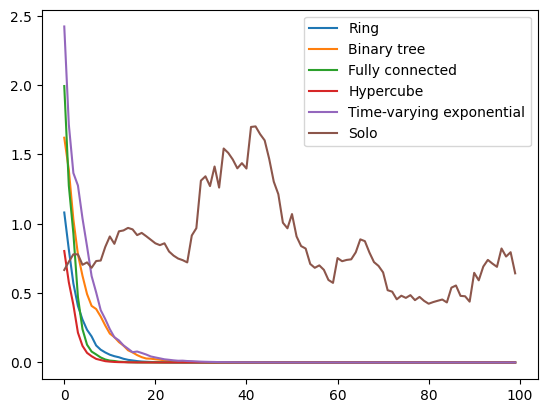

In [6]:
d = 4
n = 32
T = 100

topologies = [
        "Ring",
        "Binary tree",
        "Fully connected",
        "Hypercube",
        "Time-varying exponential",
        "Solo",

    ]

DSGD_toypbm(0.4, d, n, T, topologies, True)


In [7]:
def list_learning_rates():
    '''
    Creating the list of learning_rates for the two next algorithms
    '''
    li = []
    for k in range(-2, 0):
        for j in range(1, 10):
            li.append(j*10**k)
    for k in range(9):
        li.append(1. + k/10)
    return li

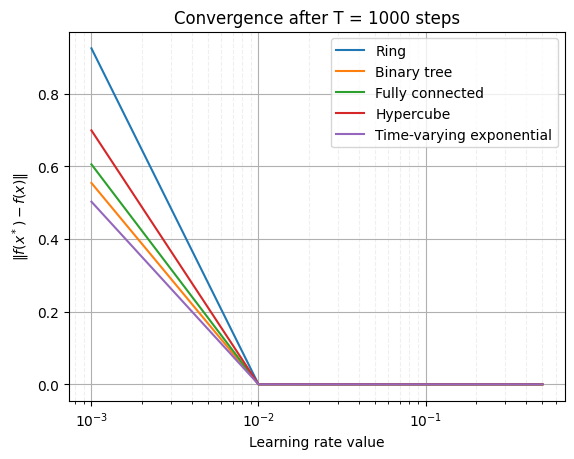

In [8]:
def learning_rate_dependency(d, n, T, topologies):
    """
    Plotting the value of the loss function after T steps for a given set of topologies, depending on the value of the learning rate

    Inputs :
    ------------
    lr: learning rate
    d: dimension
    n: number of agents
    topology: the gossip matrix
    T_max: max number of time steps
    epsilon: the convergence value
    """
    learning_rates_10 = [10**k for k in range(-3, 0)]
    learning_rates_5 = [5*10**k for k in range(-2, 0)]
    learning_rates = np.sort(learning_rates_10 + learning_rates_5)
    matrix = np.zeros((len(learning_rates), len(topologies)))
    fig, ax = plt.subplots()
    for lr, k in zip(learning_rates, range(len(learning_rates))):
        matrix[k,:] = np.array(DSGD_toypbm(lr, d, n, T, topologies, False))
    for topology, j in zip(topologies, range(len(topologies))):
        ax.plot(learning_rates, matrix[:,j], label = topology)
        ax.set_xscale('log')
        ax.legend()
    ax.set_ylabel(f'$\| f(x^*) - f(x) \| $')
    ax.set_xlabel('Learning rate value')
    ax.set_title('Convergence after T = {} steps'.format(T))
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2, linestyle='--')
    plt.show()

learning_rate_dependency(d, n, 1000, topologies[:-1])

C:\Users\hdupr\AppData\Roaming\Python\Python39\site-packages\numpy\linalg\linalg.py:2541: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\hdupr\AppData\Roaming\Python\Python39\site-packages\numpy\linalg\linalg.py:2542: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
C:\Users\hdupr\AppData\Local\Temp\ipykernel_8452\1737505386.py:27: RuntimeWarning: overflow encountered in multiply
  X[i,:] = X[i,:] - lr * v.dot(v.T).dot(X[i,:])


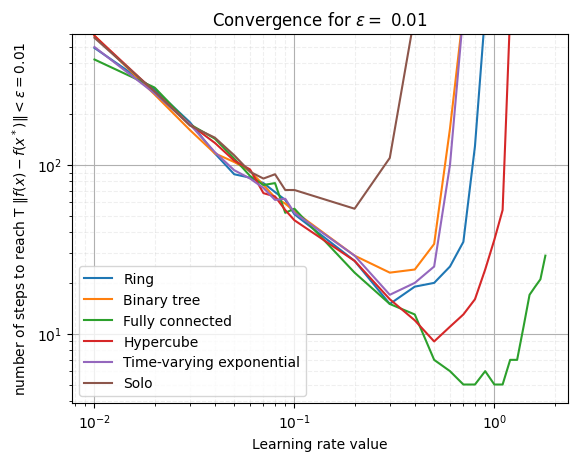

In [9]:
def DSGD_toypbm_epsilon(lr, d, n, topology, T_max, epsilon):
    """
    D-SGD algorithm for the toy-problem defined in section 3 (minimization of 1/2*||x||^2). This function returns
    the number of steps needed for the mean of the model in norm to be < epsilon

    Inputs :
    ------------
    lr: learning rate
    d: dimension
    n: number of agents
    topology: the gossip matrix
    T_max: max number of time steps
    epsilon: the convergence value
    """
    if topology != "Time-varying exponential":
        W = Matrix.w(scheme_for_string(topology, num_workers=n)).numpy()            
    x0 = rd.normal(0,1, size = (d))
    X = np.block([[x0]]*n)
    norm = np.mean(np.linalg.norm(X, axis = 1, ord = 2))
    T = 0
    while (np.abs(norm) > epsilon and T < T_max):
        if topology == "Time-varying exponential":
            W = scheme_for_string(topology, num_workers=n).w(T).numpy()
        T += 1
        for i in range(n):
            v = rd.normal(0,1, size = (d,1))
            X[i,:] = X[i,:] - lr * v.dot(v.T).dot(X[i,:])
        X = W.dot(X)
        norm = np.mean(np.linalg.norm(X, axis = 1, ord = 2))
    return T, norm





def learning_rate_dependency_number_of_steps(d, n, topologies, T_max, epsilon):
    '''
    Plotting the number of steps needed depending on the value of the learning rate and the topology to reach an error of the loss function < epsilon.
    
    Inputs :
    ----------
    d: dimension
    n: number of agents
    topologies: the gossip matrix
    T_max: max number of time steps
    epsilon: the convergence value
    '''
    learning_rates = list_learning_rates()
    matrix_T = np.zeros((len(learning_rates), len(topologies)))
    fig, ax = plt.subplots()
    for topology, j in zip(topologies, range(len(topologies))):
        for lr, k in zip(learning_rates, range(len(learning_rates))):
            matrix_T[k,j] = DSGD_toypbm_epsilon(lr, d, n, topology, T_max, epsilon)[0]  
        ax.plot(learning_rates, matrix_T[:,j], label = topology)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
    ax.set_ylabel(f'number of steps to reach T $\| f(x) - f(x^*)\| < \epsilon = ${epsilon}')
    ax.set_xlabel('Learning rate value')
    ax.set_ylim(top = 600)
    ax.set_title(f'Convergence for $\epsilon =$ {epsilon}')
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2, linestyle='--')
    plt.show()
learning_rate_dependency_number_of_steps(d, n, topologies, 800, 0.01)

In [10]:
def nW(gamma, W):
    """
    Computes the effective number of neighbours of the gossip matrix W for the decay parameter gamma
    """
    lambdas = np.linalg.eigvals(W)
    denominator = np.mean(lambdas**2 / (1 - gamma*lambdas**2))
    return 1/(1-gamma) * 1/denominator

In [11]:
# The effective number of neighbours for the alone topology (W = I) should be 1 independently of gamma
nW(.5, np.eye(10))

1.0

In [12]:
def rate_toypbm(lr, zeta, W):
    """
    Computes the convergence rate of D-SGD in the toy-problem case

    Inputs:
    ----------------
    lr: learning rate of D-SGD
    zeta: noise level (= d + 2 in the case of the toy-problem in dimension d)
    W: gossip matrix used for D-SGD

    Outputs:
    ----------------
    r: convergence rate of D-SGD
    """
    f_tosolve = lambda r : r - (1 - (1 - lr)**2 - (zeta - 1) * lr**2 / nW((1-lr)**2 / (1-r), W))
    r = optim.fsolve(f_tosolve)
    return r

In [13]:
rate_toypbm(0.5, 6, np.eye(10))

TypeError: fsolve() missing 1 required positional argument: 'x0'